In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv
/kaggle/input/forecaststicker/cbfit_Singapore
/kaggle/input/forecaststicker/cbfit_Italy
/kaggle/input/forecaststicker/cbfit_Finland
/kaggle/input/forecaststicker/cbfit_Canada
/kaggle/input/forecaststicker/cbfit_Norway
/kaggle/input/forecaststicker/cbfit_Kenya
/kaggle/input/forecaststicker/__results___files/__results___9_0.png
/kaggle/input/forecaststicker/__results___files/__results___60_1.png
/kaggle/input/forecaststicker/__results___files/__results___12_0.png
/kaggle/input/forecaststicker/catboost_info/test_error.tsv
/kaggle/input/forecaststicker/catboost_info/learn_error.tsv
/kaggle/input/forecaststicker/catboost_info/catboost_training.json
/kaggle/input/forecaststicker/catboost_info/time_left.tsv
/kaggle/input/forecaststicker/catboost_info/learn/events.out.tfevents
/kaggle/input/forecaststicker/catboost_info/test/events.out.tfevents

In [2]:
!pip install optuna-integration[catboost]
!pip install -U holidays

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.57
    Uninstalling holidays-0.57:
      Successfully uninstalled holidays-0.57


In [3]:
!pip install -U pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 49.3 MB/s eta 0:00:00


In [4]:
import statsmodels

In [5]:
import pandas as pd
import numpy as np
import optuna
import catboost as cb
import matplotlib
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from optuna.integration import CatBoostPruningCallback
import pycountry 
import holidays




In [6]:
df_train=pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
df_test=pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')



In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [8]:
df_train['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [9]:
df_train['product'].unique()

array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
       'Kerneler Dark Mode'], dtype=object)

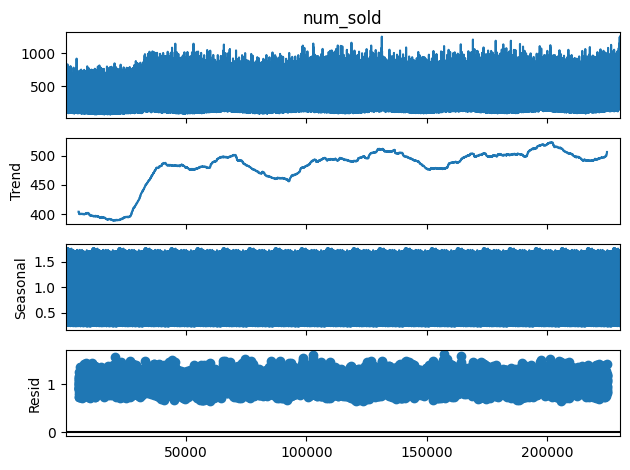

In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Generate synthetic time series data
np.random.seed(42)
#df_train['date']=pd.to_datetime(df_train['date'])
#df_train=df_train.set_index('date')
df=df_train['num_sold']

#time = pd.date_range(start=df_train['date'].min, end=df_train['date'].max, periods=365, freq='D')
#series = 10 + 0.05 * np.arange(100) + np.sin(2 * np.pi * time.dayofyear / 365) + np.random.normal(0, 1, 100)
#df = pd.DataFrame({'date': time, 'value': series}).set_index('date')

# Decompose time series
decomposition = seasonal_decompose(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'], model='multiplicative', period=600)  # Set period according to data frequency

# Plot components
decomposition.plot()
plt.show()


In [11]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_result = adfuller(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'])

# Print results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
if adf_result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")


ADF Statistic: -6.129147123657372
p-value: 8.484833374009022e-08
The series is stationary.


In [12]:
from statsmodels.tsa.stattools import kpss

# Perform KPSS test
kpss_result = kpss(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'], regression='c')

# Print results
print("KPSS Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])
if kpss_result[1] < 0.05:
    print("The series is not stationary (has a trend).")
else:
    print("The series is stationary.")

KPSS Statistic: 0.7976600279714846
p-value: 0.01
The series is not stationary (has a trend).


<ipython-input-12-b1e5399dac4b>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Stickers')]['num_sold'], regression='c')


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


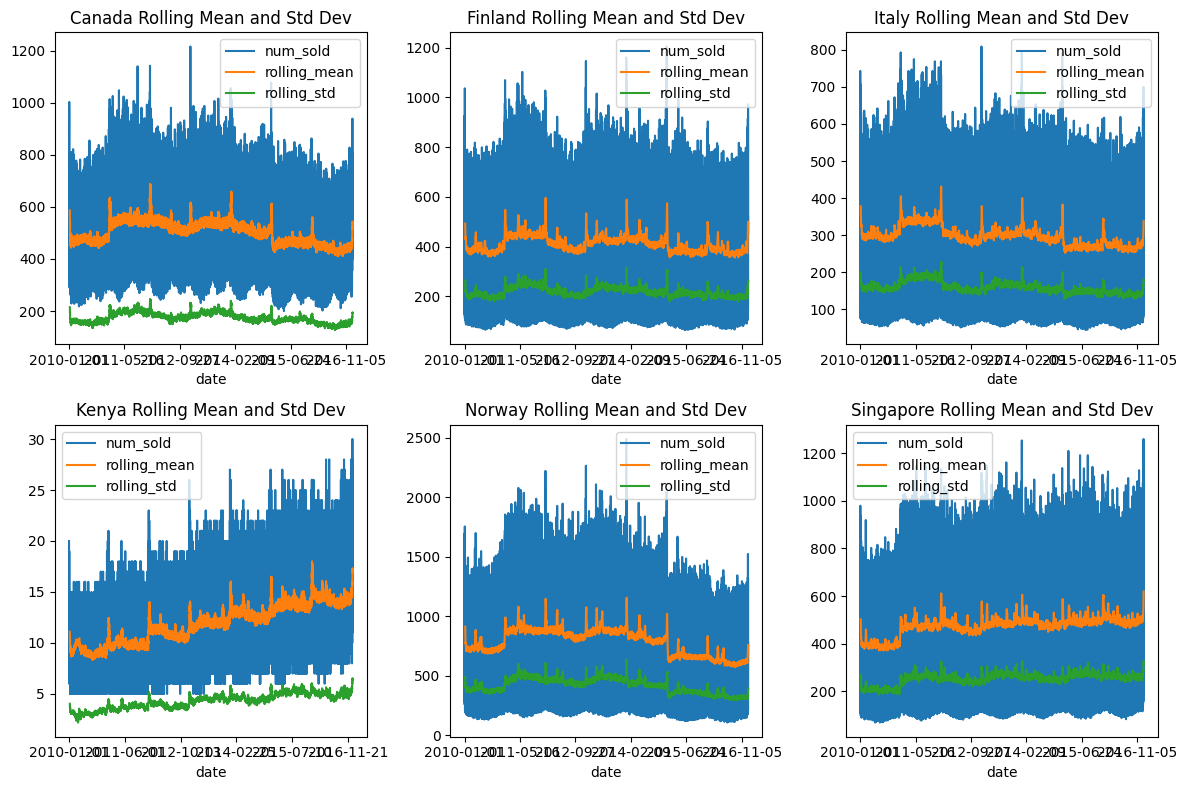

In [14]:
# Plot showing timeseries attributes: trend, seasonality 

# Create subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()
countrylist=df_train['country'].unique().tolist()
# Loop through each subplot and plot
for i, ax in enumerate(axes):
    df=df_train[(df_train['country']==countrylist[i]) & (df_train['store']=='Discount Stickers')][['date','num_sold']]
    df.dropna(inplace=True)
    df.set_index('date',inplace=True)
    df['rolling_mean'] = df['num_sold'].rolling(window=30).mean()
    df['rolling_std'] = df['num_sold'].rolling(window=30).std()
    df[['num_sold', 'rolling_mean', 'rolling_std']].plot(ax=ax,title=f'{countrylist[i]} Rolling Mean and Std Dev')

plt.tight_layout()

# Show the plot
plt.show()
    

In [15]:
df_train[(df_train['country']=='Singapore') & (df_train['store']=='Discount Sticker')]['num_sold']

Series([], Name: num_sold, dtype: float64)

In [16]:


def get_alpha2_code(country_name):
  """
  Gets the ISO 3166-1 Alpha-2 country code for the given country name.

  Args:
    country_name: The name of the country.

  Returns:
    The ISO 3166-1 Alpha-2 country code, or None if the country is not found.
  """
  try:
    country = pycountry.countries.search_fuzzy(country_name)[0]
    return country.alpha_2
  except LookupError:
    return None



In [17]:
# Function to create holiday sets for each country
def generate_country_holidays(countries, start_year, end_year):
    country_holidays = {}
    for country in countries:
        # Generate a holiday set for the range of years
        country_holidays[country] = holidays.CountryHoliday(country, years=range(start_year, end_year + 1)) 
    return country_holidays


In [18]:
def consecutive_days_visited(df):
    """
    Calculates the number of consecutive days a store was visited.

    Args:
        df: pandas DataFrame with columns 'date', 'country', 'store'

    Returns:
        pandas DataFrame with an additional column 'consecutive_days' 
    """

    # Ensure date index is sorted
    df = df.sort_index()

    # Group by 'country' and 'store'
    grouped = df.groupby(['country', 'store'])

    # Calculate consecutive days within each group
    df['consecutive_days'] = (grouped.indices - grouped.indices.min()).dt.days + 1

    return df


In [19]:
allcountries=df_train['country'].unique()
countrycodes = list(map(lambda x:get_alpha2_code(x),allcountries)) 
unique_countries = [cc for cc in countrycodes if cc is not None]
print(countrycodes)

['CA', 'FI', 'IT', 'KE', 'NO', 'SG']


In [20]:
df_train['Day']=pd.to_datetime(df_train['date']).dt.strftime("%d")
df_train['Month']=pd.to_datetime(df_train['date']).dt.strftime("%m")
df_train['Year']=pd.to_datetime(df_train['date']).dt.strftime("%Y")
df_train['Day_of_week']=pd.to_datetime(df_train['date']).dt.dayofweek


In [21]:
df_train['store']=df_train['store'].astype('category')
df_train['country']=df_train['country'].astype('category')
df_train['product']=df_train['product'].astype('category')
df_train['Day']=df_train['Day'].astype('category')
df_train['Month']=df_train['Month'].astype('category')
df_train['Year']=df_train['Year'].astype('category')
df_train['Day_of_week']=df_train['Day_of_week'].astype('category')

In [22]:
df_test['Day']=pd.to_datetime(df_test['date']).dt.strftime("%d")
df_test['Month']=pd.to_datetime(df_test['date']).dt.strftime("%m")
df_test['Year']=pd.to_datetime(df_test['date']).dt.strftime("%Y")
df_test['Day_of_week']=pd.to_datetime(df_test['date']).dt.dayofweek

In [23]:
df_test['store']=df_test['store'].astype('category')
df_test['country']=df_test['country'].astype('category')
df_test['product']=df_test['product'].astype('category')
df_test['Day']=df_test['Day'].astype('category')
df_test['Month']=df_test['Month'].astype('category')
df_test['Year']=df_test['Year'].astype('category')
df_test['Day_of_week']=df_test['Day_of_week'].astype('category')

In [24]:
df_train['date']=pd.to_datetime(df_train['date'])
df_test['date']=pd.to_datetime(df_test['date'])

In [25]:
df_train['previous_visit']=df_train.reset_index().groupby(by=['country','store'])[['date']].diff()

<ipython-input-25-a9a4f327ce0c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train['previous_visit']=df_train.reset_index().groupby(by=['country','store'])[['date']].diff()


In [26]:
df_train['consec_days']=df_train.groupby(by=['country','store'])[['previous_visit']].cumsum()

<ipython-input-26-9b789beb13f0>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train['consec_days']=df_train.groupby(by=['country','store'])[['previous_visit']].cumsum()


In [27]:
df_test['previous_visit']=df_test.reset_index().groupby(by=['country','store'])[['date']].diff()
df_test['consec_days']=df_test.groupby(by=['country','store'])[['previous_visit']].cumsum()

<ipython-input-27-b64440241ea2>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test['previous_visit']=df_test.reset_index().groupby(by=['country','store'])[['date']].diff()
<ipython-input-27-b64440241ea2>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test['consec_days']=df_test.groupby(by=['country','store'])[['previous_visit']].cumsum()


In [28]:
df_train.set_index('date',inplace=True)
Startmin=df_train.index.min()
df_train['days_since_start'] = (df_train.index - Startmin).days

# Add cycle hints based on time 
df_train['sin_year'] = np.sin(2 * np.pi * df_train['days_since_start'] / 365)
df_train['cos_year'] = np.cos(2 * np.pi * df_train['days_since_start'] / 365)
df_train['sin_month'] = np.sin(2 * np.pi * df_train['days_since_start'] / 30)
df_train['cos_month'] = np.cos(2 * np.pi * df_train['days_since_start'] / 30)

df_test.set_index('date',inplace=True)
df_test['days_since_start'] = (df_test.index - Startmin).days

# Add cycle hints based on time 
df_test['sin_year'] = np.sin(2 * np.pi * df_test['days_since_start'] / 365)
df_test['cos_year'] = np.cos(2 * np.pi * df_test['days_since_start'] / 365)
df_test['sin_month'] = np.sin(2 * np.pi * df_test['days_since_start'] / 30)
df_test['cos_month'] = np.cos(2 * np.pi * df_test['days_since_start'] / 30)

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   date              230130 non-null  datetime64[ns] 
 1   id                230130 non-null  int64          
 2   country           230130 non-null  category       
 3   store             230130 non-null  category       
 4   product           230130 non-null  category       
 5   num_sold          221259 non-null  float64        
 6   Day               230130 non-null  category       
 7   Month             230130 non-null  category       
 8   Year              230130 non-null  category       
 9   Day_of_week       230130 non-null  category       
 10  previous_visit    230112 non-null  timedelta64[ns]
 11  consec_days       230112 non-null  timedelta64[ns]
 12  days_since_start  230130 non-null  int64          
 13  sin_year          230130 non-null  float64  

In [30]:
df_train[(df_train['country']=='Norway') & (df_train['store']=='Discount Stickers') & (df_train['previous_visit'].astype('int')>0)].consec_days.max

<bound method Series.max of 150         1 days
240         2 days
330         3 days
420         4 days
510         5 days
            ...   
229740   2552 days
229830   2553 days
229920   2554 days
230010   2555 days
230100   2556 days
Name: consec_days, Length: 2556, dtype: timedelta64[ns]>

In [31]:
#Get country

#Get holidays for each country
#allcountries.append("weirdcountry")
country_holidays={}

#df_train['date']=pd.to_datetime(df_train['date'])
start_year = df_train['date'].dt.year.min()
end_year = df_train['date'].dt.year.max()

country_holidays = generate_country_holidays(unique_countries, start_year, end_year)
holiday_df = pd.DataFrame([
    {'date': date, 'country_code': country, 'country': cname}
    for country in unique_countries
    for date in country_holidays[country]
    for cname in [pycountry.countries.get(alpha_2=cc).name for cc in unique_countries]]
)
holiday_df['is_holiday'] = 1
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df.drop('country_code',axis=1,inplace=True)

df_train = df_train.merge(holiday_df, on=['date', 'country'], how='left').fillna({'is_holiday': 0})

In [32]:
start_year = df_test['date'].dt.year.min()
end_year = df_test['date'].dt.year.max()
#unique_countries = [cc for cc in countrycodes if cc is not None]
country_holidays = generate_country_holidays(unique_countries, start_year, end_year)

holiday_df = pd.DataFrame([
    {'date': date, 'country_code': country, 'country': cname}
    for country in unique_countries
    for date in country_holidays[country]
    for cname in [pycountry.countries.get(alpha_2=cc).name for cc in unique_countries]]
)
holiday_df['is_holiday']=1
holiday_df['date']=pd.to_datetime(holiday_df['date'])
holiday_df.drop('country_code',axis=1,inplace=True)

df_test = df_test.merge(holiday_df, on=['date', 'country'], how='left').fillna({'is_holiday': 0})


In [33]:
df_test['is_holiday']=df_test['is_holiday'].astype(int)
df_test['is_holiday'].value_counts()

is_holiday
0    88290
1    18270
Name: count, dtype: int64

In [34]:
df_train.set_index('date',inplace=True)
#df_test.set_index('date',inplace=True)

In [35]:
#Graph for intrpolate is changing too much
#Not interpolate but just drop Na is better
#Interpolate missing num_sold

#df_train['date']=pd.to_datetime(df_train['date'])
#df = df_train.set_index('date')

# df_train = df_train.sort_values(by=['country', 'store', 'product', 'date'])

# # Impute NaN with interpolation (grouped by Country, Store, and Product)
# df_train['num_sold'] = df_train.groupby(['country', 'store', 'product'])['num_sold'].transform(
#     lambda group: group.interpolate(method='linear',limit=None,limit_direction='both').ffill().bfill()
# )
#df['num_sold'].isna().any()

In [36]:
#condition = (df.num_sold.notna()) & (df['country']=='Canada') & (df['store']=='Discount Stickers') & (df['product']=='Holographic Goose')
#df[condition]


In [37]:
##Get num_sold NaN product store and country
#t=df[df.num_sold.isna()].groupby(['country','store','product'])['product'].value_counts().to_dict()

In [38]:
#Country store and product that have NaN
# for  k,v in t.items():
#     if v!=0:
#         print(k,v)

In [39]:
#Find Holographic Goose num_sold in each country
nan_product = df_train[(df_train['product']=='Holographic Goose') & (df_train['num_sold'].notna())].groupby(['country'])['num_sold']
print("Mean")
print(nan_product.mean())
print("Median")
print(nan_product.median())
print("Mode")
print(nan_product.agg(pd.Series.mode))
print("Min")
print(nan_product.min())
print("Max")
print(nan_product.max())

Mean
country
Canada       242.974170
Finland      179.209850
Italy        129.627508
Kenya          5.800233
Norway       341.143664
Singapore    206.325646
Name: num_sold, dtype: float64
Median
country
Canada       235.0
Finland      190.0
Italy        137.0
Kenya          6.0
Norway       353.0
Singapore    219.0
Name: num_sold, dtype: float64
Mode
country
Canada       218.0
Finland       91.0
Italy         64.0
Kenya          5.0
Norway       171.0
Singapore    107.0
Name: num_sold, dtype: float64
Min
country
Canada       200.0
Finland       65.0
Italy         44.0
Kenya          5.0
Norway       105.0
Singapore     69.0
Name: num_sold, dtype: float64
Max
country
Canada       449.0
Finland      491.0
Italy        318.0
Kenya         11.0
Norway       908.0
Singapore    469.0
Name: num_sold, dtype: float64


Impute Canana NaN with 218.0 
Impute Kenya NaN with 5.0

In [40]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [41]:
df_train.isna().any()

id                  False
country             False
store               False
product             False
num_sold            False
Day                 False
Month               False
Year                False
Day_of_week         False
previous_visit      False
consec_days         False
days_since_start    False
sin_year            False
cos_year            False
sin_month           False
cos_month           False
is_holiday          False
dtype: bool

In [42]:
#Impute Canada with 218
#df.loc[df['country']=='Canada',['num_sold']]=df.loc[df['country']=='Canada',['num_sold']].fillna(218.0)

In [43]:
#Impute Kenya with 5
#df.loc[df['country']=='Kenya',['num_sold']]=df.loc[df['country']=='Kenya',['num_sold']].fillna(5.0)

In [44]:
# nsmode = df_train['num_sold'].mode()
# df_train['num_sold']=df_train['num_sold'].fillna(nsmode[0])

In [45]:
#Get date back to feature after interpolation
df_train=df_train.reset_index()

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240169 entries, 0 to 240168
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype          
---  ------            --------------   -----          
 0   date              240169 non-null  datetime64[ns] 
 1   id                240169 non-null  int64          
 2   country           240169 non-null  object         
 3   store             240169 non-null  category       
 4   product           240169 non-null  category       
 5   num_sold          240169 non-null  float64        
 6   Day               240169 non-null  category       
 7   Month             240169 non-null  category       
 8   Year              240169 non-null  category       
 9   Day_of_week       240169 non-null  category       
 10  previous_visit    240169 non-null  timedelta64[ns]
 11  consec_days       240169 non-null  timedelta64[ns]
 12  days_since_start  240169 non-null  int64          
 13  sin_year          240169 non-null  float64  

In [47]:
df_train['is_holiday']=df_train['is_holiday'].astype('int')
df_train['previous_visit']=pd.to_numeric(df_train['previous_visit'].dt.days,errors='coerce')
df_train['consec_days']=pd.to_numeric(df_train['consec_days'].dt.days,errors='coerce')
df_train['country']=df_train['country'].astype('category')

df_test['is_holiday']=df_test['is_holiday'].astype('int')
df_test['previous_visit']=pd.to_numeric(df_test['previous_visit'].dt.days,errors='coerce')
df_test['consec_days']=pd.to_numeric(df_test['consec_days'].dt.days,errors='coerce')
df_test['country']=df_test['country'].astype('category')

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240169 entries, 0 to 240168
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              240169 non-null  datetime64[ns]
 1   id                240169 non-null  int64         
 2   country           240169 non-null  category      
 3   store             240169 non-null  category      
 4   product           240169 non-null  category      
 5   num_sold          240169 non-null  float64       
 6   Day               240169 non-null  category      
 7   Month             240169 non-null  category      
 8   Year              240169 non-null  category      
 9   Day_of_week       240169 non-null  category      
 10  previous_visit    240169 non-null  int64         
 11  consec_days       240169 non-null  int64         
 12  days_since_start  240169 non-null  int64         
 13  sin_year          240169 non-null  float64       
 14  cos_

In [49]:
#Split data according to country into
from catboost import Pool
country_train_pool={}
country_valid_pool={}
for c in countrylist:
    df=df_train[df_train['country']==c]
    train_x, valid_x, train_y, valid_y = train_test_split(df.drop(['id','num_sold','country'],axis=1),df['num_sold'],test_size=0.25)
    cats=df.select_dtypes('category').columns.to_list()
    cats.remove('country')
    country_train_pool[c]=Pool(train_x,label=train_y,cat_features=cats)
    country_valid_pool[c]=Pool(valid_x,label=valid_y,cat_features=cats)
    

In [50]:
from functools import partial

def objective(trial: optuna.Trial, country) -> float:
    #data, target = load_breast_cancer(return_X_y=True)
    #train_x, valid_x, train_y, valid_y = train_test_split(df_train.drop(['id','num_sold','date'],axis=1), df_train['num_sold'], test_size=0.25)
    #cats=df_train.select_dtypes('category').columns
    
    param = {
        "iterations":trial.suggest_int("iterations",1000,3000),
        "objective": trial.suggest_categorical("objective", ["MAPE"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.7, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "MAPE",
        "cat_features": cats,
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostRegressor(**param)

    pruning_callback = CatBoostPruningCallback(trial, "MAPE")
    gbm.fit(
       # train_x,
       # train_y,
       # eval_set=[(valid_x, valid_y)],
        country_train_pool[c],
        eval_set=country_valid_pool[c],
        verbose=0,
        early_stopping_rounds=300,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    mape = mean_absolute_percentage_error(valid_y, pred_labels)
    return mape


In [51]:
from functools import partial 

country_best_params={}
for c in countrylist:
    objective = partial(objective, country = c)
    
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="minimize"
    )
    study.optimize(objective, n_trials=100, timeout=600)
    
    print("Number of finished trials: {}".format(len(study.trials)))
    
    print(f'{c} Best trial:')
    trial = study.best_trial
    
    print("  Value: {}".format(trial.value))
    
    print(f"{c}  Params: ")
    country_best_params[c]=trial.params.copy()
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        

<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from

Number of finished trials: 33
Canada Best trial:
  Value: 0.2415019844192218
Canada  Params: 
    iterations: 1590
    objective: MAPE
    colsample_bylevel: 0.3171002078702047
    depth: 5
    boosting_type: Ordered
    bootstrap_type: MVS


<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from

Number of finished trials: 15
Finland Best trial:
  Value: 0.17843838539672494
Finland  Params: 
    iterations: 2918
    objective: MAPE
    colsample_bylevel: 0.5438806344007332
    depth: 10
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 5.166226737445987


<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from

Number of finished trials: 12
Italy Best trial:
  Value: 0.3975639087132591
Italy  Params: 
    iterations: 1483
    objective: MAPE
    colsample_bylevel: 0.45439054697184805
    depth: 9
    boosting_type: Ordered
    bootstrap_type: MVS


<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from

Number of finished trials: 21
Kenya Best trial:
  Value: 0.9744368417082563
Kenya  Params: 
    iterations: 1201
    objective: MAPE
    colsample_bylevel: 0.6456556129234882
    depth: 9
    boosting_type: Ordered
    bootstrap_type: MVS


<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from

Number of finished trials: 39
Norway Best trial:
  Value: 0.4128500621546934
Norway  Params: 
    iterations: 2251
    objective: MAPE
    colsample_bylevel: 0.047870079938907836
    depth: 5
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 1.5742182547971917


<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "MAPE")
<ipython-input-50-4b0a9741c145>:29: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from

Number of finished trials: 13
Singapore Best trial:
  Value: 0.07166228053808053
Singapore  Params: 
    iterations: 2999
    objective: MAPE
    colsample_bylevel: 0.19311540184140183
    depth: 10
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.24406982469335414


In [52]:
#print(study.best_params)

In [53]:
# from catboost import Pool,cv
# cats=df_train.select_dtypes('category').columns
# features=df_train.drop(['id','num_sold','date'],axis=1).columns
# train_pool = Pool(data=df_train.drop(['id','num_sold','date'],axis=1),
#              label=df_train['num_sold'],
#              cat_features=cats.to_list())

In [54]:
# from catboost import Pool,cv

#              #feature_names=features)


# # params = {"iterations": 1000,
# #           "depth": 4,
# #           "loss_function": "MAPE",
# #           "verbose": False}

# scores = cv(train_pool,
#             study.best_params,
#            fold_count=5,
#             verbose=0,
#            )

# print(scores)

In [55]:
#print(scores)

In [56]:
#hyperdict=optuna.importance.get_param_importances(study)

In [57]:
#print(hyperdict)

In [58]:
for p,v in country_best_params.items():
    print(p)
    print(v)

Canada
{'iterations': 1590, 'objective': 'MAPE', 'colsample_bylevel': 0.3171002078702047, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
Finland
{'iterations': 2918, 'objective': 'MAPE', 'colsample_bylevel': 0.5438806344007332, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.166226737445987}
Italy
{'iterations': 1483, 'objective': 'MAPE', 'colsample_bylevel': 0.45439054697184805, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
Kenya
{'iterations': 1201, 'objective': 'MAPE', 'colsample_bylevel': 0.6456556129234882, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
Norway
{'iterations': 2251, 'objective': 'MAPE', 'colsample_bylevel': 0.047870079938907836, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.5742182547971917}
Singapore
{'iterations': 2999, 'objective': 'MAPE', 'colsample_bylevel': 0.19311540184140183, 'depth': 10, 'boosting_type': 'Orde

In [59]:
#Train model with best param and iteration>1000 before prediction
country_model={}
for c in countrylist:
    country_model[c]=cb.CatBoostRegressor(**country_best_params[c],verbose=0)
    country_model[c].fit(country_train_pool[c],eval_set=country_valid_pool[c])
    country_model[c].save_model(f'cbfit_{c}')

In [60]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106452 entries, 6 to 106559
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              106452 non-null  datetime64[ns]
 1   id                106452 non-null  int64         
 2   country           106452 non-null  category      
 3   store             106452 non-null  category      
 4   product           106452 non-null  category      
 5   Day               106452 non-null  category      
 6   Month             106452 non-null  category      
 7   Year              106452 non-null  category      
 8   Day_of_week       106452 non-null  category      
 9   previous_visit    106452 non-null  int64         
 10  consec_days       106452 non-null  int64         
 11  days_since_start  106452 non-null  int64         
 12  sin_year          106452 non-null  float64       
 13  cos_year          106452 non-null  float64       
 14  sin_month

<ipython-input-61-d8af3b9fefac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_sold']=country_predicts[c]
<ipython-input-61-d8af3b9fefac>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rolling_mean'] = df['num_sold'].rolling(window=30).mean()
<ipython-input-61-d8af3b9fefac>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

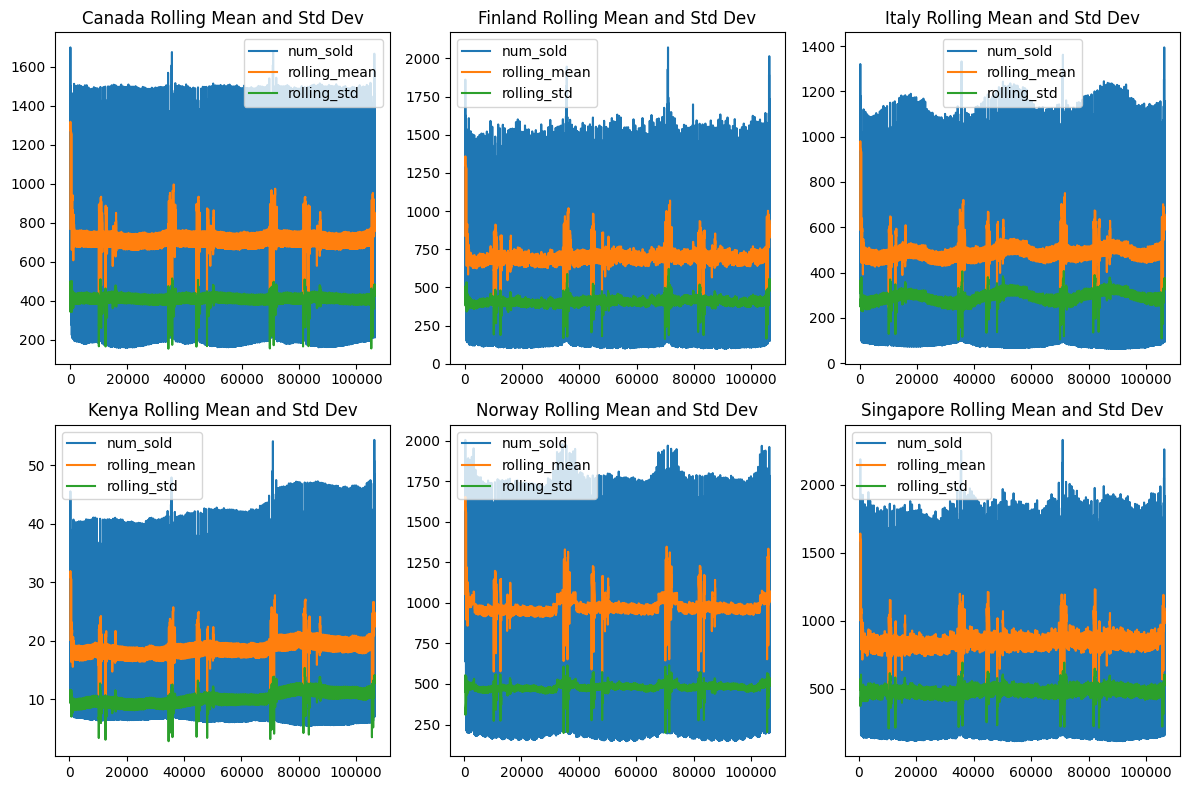

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
testcountrylist=df_test['country'].unique().tolist()
country_predicts={}
for i,c in enumerate(testcountrylist):
    df=df_test[df_test['country']==c]
    country_predicts[c] = country_model[c].predict(df.drop(['id','country'],axis=1))
    df['num_sold']=country_predicts[c]
    df.set_index('date')
    df['rolling_mean'] = df['num_sold'].rolling(window=30).mean()
    df['rolling_std'] = df['num_sold'].rolling(window=30).std()
    df[['num_sold', 'rolling_mean', 'rolling_std']].plot(ax=axes.flat[i],title=f'{c} Rolling Mean and Std Dev')

plt.tight_layout()
plt.show()

In [62]:
cdf={}
for c in testcountrylist:
    cid=df_test[df_test['country']==c]['id']
    cdf[c]=pd.concat([cid,pd.DataFrame(np.round(country_predicts[c],0),columns=['num_sold'])],axis=1)

In [63]:
temp=pd.DataFrame(columns=['id','num_sold'])
for c in countrylist:
    temp=pd.concat([temp,cdf[c]],ignore_index=True,verify_integrity=True)

<ipython-input-63-79f4b613acb8>:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temp=pd.concat([temp,cdf[c]],ignore_index=True,verify_integrity=True)


In [64]:
temp.to_csv('submission_6country.csv',index=False)

In [65]:
#pd.concat([df_test['id'],pd.DataFrame(np.round(predicts,0),columns=['num_sold'])],axis=1).reset_index(drop=True).to_csv('submission_impute_dropna_holidays_conseddays.csv',index=False)